In [1]:
!pip install pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import json
import zipfile
import subprocess
import shutil
import getpass
import math
import numpy
import pandas
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image,ImageReadMode
import matplotlib.pyplot as plt
import plotly.express as px
from pytorch_metric_learning import losses, regularizers
from torchsummary import summary

In [3]:
torch.manual_seed(20)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
dataset_save_dir = './dataset'

In [9]:
def one_hot_encode(val):
    arr = numpy.zeros((6,), dtype=int)
    arr[val] = 1
    return arr

def get_bucket_id(age):
  age_floor = int(age)
  if age_floor >= 0 and age_floor <= 5: return 0
  elif age_floor >= 6 and age_floor <= 12: return 1
  elif age_floor >= 13 and age_floor <= 19: return 2
  elif age_floor >= 20 and age_floor <= 29: return 3
  elif age_floor >= 30 and age_floor <= 59: return 4
  else: return 5

def get_ground_truth(age):
  return one_hot_encode(get_bucket_id(age))

In [10]:
def train(dataloader, model, optimizer, loss_function, loss_optimizer):
    torch.cuda.empty_cache()
    size = len(dataloader.dataset)
    model.train()
    loss_tot = 0.0
    num = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Zeroing the gradients
        optimizer.zero_grad()
        loss_optimizer.zero_grad()

        # Get Embeddings
        embeddings = model(X)

        # Calculate Loss
        loss = loss_function(embeddings, y.argmax(1))

        # Backpropagation
        loss.backward()

        # Update
        optimizer.step()
        loss_optimizer.step()

        loss_tot += loss.item()
        num += 1
        
        X.cpu()
        y.cpu()

    # loss_tot /= num
    print(f'training loss: {(loss_tot):>0.5f}')

In [11]:
validation_accuracy = []
current_max_val_acc = 0.0
def validation(dataloader, model, loss_function):
    global current_max_val_acc
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    totalsize = 0
    loss_tot = 0.0
    num = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward With Logits
            embeddings = model(X)        
            logits = loss_function.get_logits(embeddings)
            predSoftmax = nn.Softmax(dim=1)(logits)
            loss = loss_function(embeddings,y.argmax(1))
            
            correct += (predSoftmax.argmax(1) == y.argmax(1)).sum().item()
            totalsize += predSoftmax.shape[0]
            loss_tot += loss.item()
            num += 1
            X.cpu()
            y.cpu()
            
    print(f"Correct/Total: {correct}/{totalsize}")
    correct /= totalsize
    validation_accuracy.append(correct*100)
    print(f"Validation Loss:  {(loss_tot):>0.5f}")
    print(f"Validation Accuracy: {(100*correct):>0.5f}%\n")
    current_max_val_acc = max(current_max_val_acc,100*correct)
    print(f"Current Best Validation Accuracy: {(current_max_val_acc):>0.5f}%\n")
    return loss_tot

In [12]:
class XRayToothDataset(Dataset):
    def __init__(self, cwd, img_dir, transform=None, target_height=None, target_width=None):
        self.dataset_path = cwd + '/' + img_dir
        self.transform = transform
        self.target_height = target_height
        self.target_width = target_width

    def __len__(self):
        return len(os.listdir(self.dataset_path))

    def __getitem__(self, idx):
        if idx  >= len(os.listdir(self.dataset_path)):
            print("No datafile/image at index : "+ str(idx))
            return None
        img_filename = os.listdir(self.dataset_path)[idx]
        age = float(img_filename.split("_")[1][:-4])
        age_gt = get_ground_truth(age)
        image_tensor = read_image(path=self.dataset_path + '/' + img_filename)
        image_tensor = image_tensor.reshape(1, 3, image_tensor.shape[-2], image_tensor.shape[-1])
        if self.target_height and self.target_width: # Resize the image 
            image_tensor = torch.nn.functional.interpolate(image_tensor, (self.target_height,self.target_width))
        if self.transform: image_tensor = self.transform(image_tensor) # Apply transformations
        image_tensor = (image_tensor-image_tensor.min())/(image_tensor.max()-image_tensor.min())
        return image_tensor.reshape(-1,image_tensor.shape[-2],image_tensor.shape[-1]).to(torch.float32), torch.tensor(age_gt)

In [13]:
# Data Augmentation Transformations 
data_augmentation_transformations = T.RandomChoice([
    T.RandomAffine(degrees=0), # No Augmentation
    T.Lambda(lambda x: TF.hflip(img=x)) # Horizontal Flip

    # Geometric Transformations:
    # T.RandomAffine(degrees=0, scale=(1.3,1.3)), # Scale
    # T.RandomAffine(degrees=0, translate=(0.5,0.5)), # Translate
    # T.RandomAffine(degrees=(-8, 8)), # Rotate
    # T.Lambda(lambda x: TF.hflip(img=x)), # Reflect

    # Occlusion:
    # T.Compose([T.RandomErasing(p=1, scale=(0.0008, 0.0008), ratio=(1,1))]*100), # Occlusion

    # Intensity Operations
    # T.Lambda(lambda x: TF.adjust_gamma(img=x, gamma=0.5)), # Gamma Contrast
    # T.Lambda(lambda x: TF.adjust_contrast(x, contrast_factor=2.0)), # Linear Contrast

    # Filtering:
    # T.Lambda(lambda x: TF.adjust_sharpness(img=x, sharpness_factor=4)), #Sharpen
    # T.GaussianBlur(kernel_size=(15,15), sigma=(0.01, 1)), # Gaussian Blur
])  

In [14]:
training_data = XRayToothDataset(os.getcwd(), img_dir=dataset_save_dir+'/training', transform=data_augmentation_transformations, target_height=384, target_width=384)
validation_data = XRayToothDataset(os.getcwd(), img_dir=dataset_save_dir+'/validation', transform=None, target_height=384, target_width=384)

In [15]:
from torchvision.models import resnet50, ResNet50_Weights
pretrained_resnet = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

for param in pretrained_resnet.parameters():
    param.requires_grad = False

In [16]:
summary(pretrained_resnet, (3,384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           9,408
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
         MaxPool2d-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]           4,096
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]          36,864
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
           Conv2d-11          [-1, 256, 96, 96]          16,384
      BatchNorm2d-12          [-1, 256, 96, 96]             512
           Conv2d-13          [-1, 256, 96, 96]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = pretrained_resnet 

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Linear(1000,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,256),
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [18]:
model = NeuralNetwork().to(device)

In [19]:
summary(model, (3, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           9,408
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
         MaxPool2d-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]           4,096
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]          36,864
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
           Conv2d-11          [-1, 256, 96, 96]          16,384
      BatchNorm2d-12          [-1, 256, 96, 96]             512
           Conv2d-13          [-1, 256, 96, 96]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
# Test a forward pass
with torch.no_grad():
    model.eval()
    data = training_data[0][0].reshape(-1,3,384,384).to(device)
    label = training_data[0][1].reshape(-1,6).to(device)
    embed = model(data)
    print(embed)

tensor([[ 0.1229, -0.0426,  0.0596, -0.1207,  0.0636, -0.0757,  0.0659, -0.0050,
          0.0310, -0.0078,  0.0460, -0.0981, -0.0455,  0.1200, -0.0418, -0.2162,
         -0.0781,  0.1112, -0.0122,  0.0371,  0.0997, -0.0753,  0.0591, -0.0871,
         -0.0941, -0.0969, -0.1495, -0.1043,  0.0178,  0.0270,  0.0322, -0.0395,
         -0.0981, -0.0619, -0.0765, -0.0964, -0.0561,  0.0332,  0.0087,  0.0522,
         -0.0203,  0.0721,  0.0700, -0.0771,  0.0330, -0.1854,  0.0961,  0.0045,
         -0.0541, -0.0705, -0.1029, -0.0333,  0.0539,  0.1482, -0.2207,  0.1004,
          0.0488,  0.1257,  0.1020, -0.1247, -0.0869,  0.0556,  0.0331, -0.1125,
         -0.0129, -0.1168,  0.0599,  0.1336, -0.0559,  0.0591, -0.0071, -0.0288,
          0.0461, -0.0509, -0.0464,  0.1547,  0.1388,  0.1205,  0.1742,  0.0462,
         -0.0223,  0.0115,  0.2496, -0.1495, -0.0267, -0.0523,  0.0812,  0.0138,
          0.1420, -0.0303, -0.2309, -0.1351,  0.0614, -0.0950,  0.0939, -0.0649,
         -0.1391, -0.1525, -

In [21]:
# Training Hyperparameters
epochs = 50
batch_size = 100
learning_rate = 1e-2
margin_loss_learning_rate = 9e-1
momentum=0.9
weight_decay=1e-2

In [22]:
training_data_loader = DataLoader(training_data, batch_size, shuffle = True)
validation_data_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [23]:
# Loss
margin_loss_regularizer = regularizers.RegularFaceRegularizer()
margin_loss_function = losses.ArcFaceLoss(6, 256, margin=34.3, scale=1, weight_regularizer=margin_loss_regularizer).to(device)

In [24]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_optimizer = torch.optim.SGD(margin_loss_function.parameters(), lr=margin_loss_learning_rate)

# Schedulers
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, min_lr=1e-8,verbose=True)
margin_loss_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, min_lr=1e-8,verbose=True)

In [25]:
# Training
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data_loader, model, optimizer, margin_loss_function, loss_optimizer)
    val_loss = validation(validation_data_loader, model, margin_loss_function)
    # scheduler.step(val_loss)
    # margin_loss_scheduler.step(val_loss)
print("Done!")

Epoch 1
-------------------------------
training loss: 6.43083
Correct/Total: 67/129
Validation Loss:  4.05144
Validation Accuracy: 51.93798%

Current Best Validation Accuracy: 51.93798%

Epoch 2
-------------------------------
training loss: 5.85831
Correct/Total: 67/129
Validation Loss:  4.04207
Validation Accuracy: 51.93798%

Current Best Validation Accuracy: 51.93798%

Epoch 3
-------------------------------
training loss: 5.76291
Correct/Total: 67/129
Validation Loss:  4.07209
Validation Accuracy: 51.93798%

Current Best Validation Accuracy: 51.93798%

Epoch 4
-------------------------------
training loss: 5.69359
Correct/Total: 56/129
Validation Loss:  4.11844
Validation Accuracy: 43.41085%

Current Best Validation Accuracy: 51.93798%

Epoch 5
-------------------------------
training loss: 5.63454
Correct/Total: 28/129
Validation Loss:  4.15935
Validation Accuracy: 21.70543%

Current Best Validation Accuracy: 51.93798%

Epoch 6
-------------------------------
training loss: 5.549

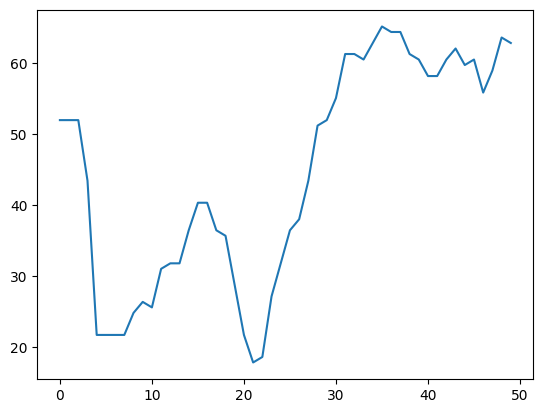

In [26]:
plt.plot(validation_accuracy)